In [0]:
! pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import cv2
import dlib
import math
import numpy as np

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [0]:
np.random.seed(42)

In [0]:
DATA_PATH = "drive/My Drive/FER/datasets/CK+48/"
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/Multi-Input-Model/"

In [0]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

fear has 75 number of images
sadness has 84 number of images
anger has 135 number of images
surprise has 249 number of images
happy has 207 number of images

total images are 750


In [0]:
TOP_EMOTIONS = ["happy", "fear", "sadness", "anger", "surprise"]

for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

750

In [0]:
%%time
print("loading images to numpy array, this will take few minutes...")

img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"loading {dir_} images to numpy arrays")
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = label
            i += 1
        label_to_text[label] = dir_
        label += 1

img_label = np_utils.to_categorical(img_label)
img_arr.shape, img_label.shape

print("\n")

loading images to numpy array, this will take few minutes...
loading fear images to numpy arrays
loading sadness images to numpy arrays
loading anger images to numpy arrays
loading surprise images to numpy arrays
loading happy images to numpy arrays


CPU times: user 429 ms, sys: 372 ms, total: 801 ms
Wall time: 5min 45s


In [0]:
label_to_text

{0: 'fear', 1: 'sadness', 2: 'anger', 3: 'surprise', 4: 'happy'}

In [0]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'anger': 2, 'fear': 0, 'happy': 4, 'sadness': 1, 'surprise': 3}

In [0]:
img_arr = img_arr / 255.

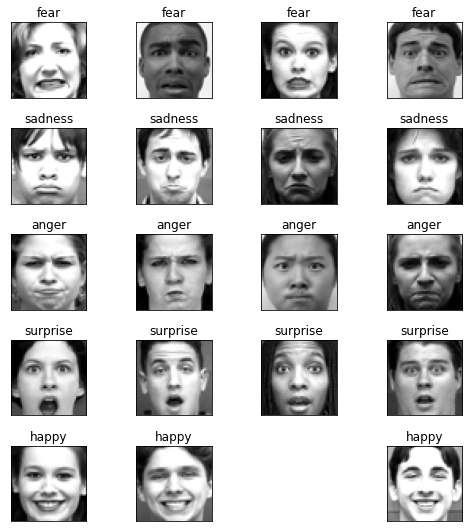

In [0]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [0]:
%%time

print("Extracting facial ROI, this may take some time")

face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(BASE_PATH+"dumps/shape_predictor_68_face_landmarks.dat")

ROI_1 = list(set(range(17,48)) - set(range(29,36)))
ROI_2 = list(range(48,68)) + [33, 4, 14]
roi1_arr = np.empty(shape=(total_images,25,50,1))
roi2_arr = np.empty(shape=(total_images,25,50,1))

count = 0
idx = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, 0)
            img_ = cv2.resize(img, (96,96))
            # img_ = cv2.equalizeHist(img_)

            faces = face_detector(img_)
            
            if faces:
                for face in faces:
                    ROI1_landmarks = []
                    ROI2_landmarks = []
                    landmarks = shape_predictor(img_, face)
                    for i in range(0, 68):
                        x = landmarks.part(i).x
                        y = landmarks.part(i).y
                        if i in ROI_1:
                            ROI1_landmarks.append((x,y))
                        if i in ROI_2:
                            ROI2_landmarks.append((x,y))

                    (x, y, w, h) = cv2.boundingRect(np.array(ROI1_landmarks))
                    roi1 = img_[y:y + h, x:x + w]
                    roi1 = cv2.resize(roi1, (50,25), interpolation=cv2.INTER_CUBIC)
                    roi1_arr[idx] = np.expand_dims(roi1, axis=2)

                    (x, y, w, h) = cv2.boundingRect(np.array(ROI2_landmarks))
                    roi2 = img_[y:y + h, x:x + w]
                    roi2 = cv2.resize(roi2, (50,25), interpolation=cv2.INTER_CUBIC)
                    roi2_arr[idx] = np.expand_dims(roi2, axis=2)

                    idx += 1
            else:
                count += 1

print(f"\ntotal images with no facial landmarks: {count}")

roi1_arr = np.array(roi1_arr)
print("ROI1", roi1_arr.shape)

roi2_arr = np.array(roi2_arr)
print("ROI2", roi2_arr.shape)

print("\n")

Extracting facial ROI, this may take some time
processing fear images...
processing sadness images...
processing anger images...
processing surprise images...
processing happy images...

total images with no facial landmarks: 0
ROI1 (750, 25, 50, 1)
ROI2 (750, 25, 50, 1)


CPU times: user 3.74 s, sys: 378 ms, total: 4.12 s
Wall time: 9.13 s


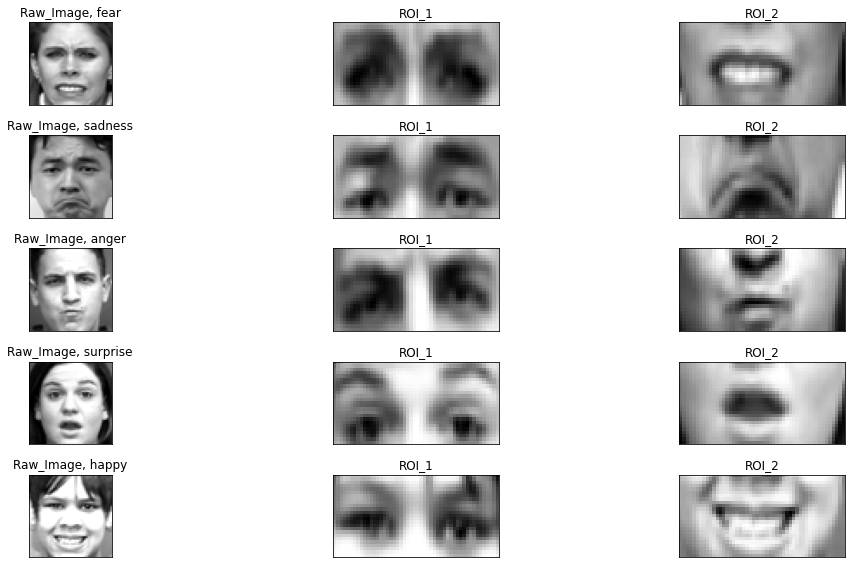

In [0]:
fig = pyplot.figure(1, (18,8))

np.random.seed(10)
idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=1, replace=False)
    sample_images = img_arr[sample_indices]
    sample_roi1 = roi1_arr[sample_indices]
    sample_roi2 = roi2_arr[sample_indices]

    for img,roi1,roi2 in zip(sample_images, sample_roi1, sample_roi2):
        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Raw_Image, {label_to_text[k]}")

        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(roi1.reshape(25,50), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("ROI_1")

        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(roi2.reshape(25,50), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("ROI_2")

        pyplot.tight_layout()

In [0]:
%%time

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

print("extracting HOG features, this will take few minutes...")

hog_features = []
hog_images = []

for dir_ in os.listdir(DATA_PATH):    
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for i,f in enumerate(os.listdir(DATA_PATH + dir_ + "/")):
            img = imread(DATA_PATH + dir_ + "/" + f, as_gray=True)
            resized_img = resize(img, (128,64))

            hog_feat, hog_img = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(2, 2), visualize=True, multichannel=False)

            hog_features.append(hog_feat)
            hog_images.append(hog_img)


hog_features = np.array(hog_features)
print("\nhog feature", hog_features.shape)

hog_images = np.array(hog_images)
print("hog image", hog_images.shape)

print("\n")

extracting HOG features, this will take few minutes...
processing fear images...
processing sadness images...
processing anger images...
processing surprise images...
processing happy images...

hog feature (750, 3780)
hog image (750, 128, 64)


CPU times: user 46.2 s, sys: 36 s, total: 1min 22s
Wall time: 43.3 s


In [0]:
Xtrain_img, Xtest_img, Xtrain_roi1, Xtest_roi1, Xtrain_roi2, Xtest_roi2, Xtrain_hogfeat, Xtest_hogfeat, Xtrain_hogimg, Xtest_hogimg, \
y_train, y_test = train_test_split(img_arr, roi1_arr, roi2_arr, hog_features, hog_images, img_label,
                shuffle=True, stratify=img_label, train_size=0.7, random_state=42)

print(Xtrain_img.shape, Xtrain_roi1.shape, Xtrain_roi2.shape, Xtrain_hogfeat.shape, Xtrain_hogimg.shape, y_train.shape)
print(Xtest_img.shape, Xtest_roi1.shape, Xtest_roi2.shape, Xtest_hogfeat.shape, Xtest_hogimg.shape, y_test.shape)

(525, 48, 48, 1) (525, 25, 50, 1) (525, 25, 50, 1) (525, 3780) (525, 128, 64) (525, 5)
(225, 48, 48, 1) (225, 25, 50, 1) (225, 25, 50, 1) (225, 3780) (225, 128, 64) (225, 5)


In [0]:
def full_image_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_DCNN")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_img'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_img')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_img'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_img')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_img')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_img')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_img'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_img')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_img'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_img')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_img')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_img')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_img'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_img')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_img'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_img')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_img')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_img')(maxpool2d_3)

    flatten = Flatten(name='flatten_dcnn_img')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_dcnn_img'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_img')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_img')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def roi1_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_ROI1")
    
    conv2d_1 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_roi1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_roi1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_roi1'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_roi1')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_roi1')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_roi1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_roi1'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_roi1')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_roi1'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_roi1')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_roi1')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_roi1')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_roi1'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_roi1')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_roi1'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_roi1')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_roi1')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_roi1')(maxpool2d_3)

    flatten = Flatten(name='flatten_roi1')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_roi1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_roi1')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_roi1')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def roi2_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_ROI2")
    
    conv2d_1 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_roi2'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_roi2')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_roi2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_roi2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_roi2')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_roi2')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_roi2'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_roi2')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_roi2'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_roi2')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_roi2')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_roi2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_roi2'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_roi2')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_roi2'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_roi2')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_roi2')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_roi2')(maxpool2d_3)

    flatten = Flatten(name='flatten_roi2')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_roi2'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_roi2')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_roi2')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def facial_HOGfeat_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_HOGfeat")
    flatten = Flatten(name="flatten_hogfeat")(model_in)
    dense1 = Dense(512, activation="elu", name="dense1_hogfeat")(flatten)
    model_out = Dropout(0.4, name='dropout1_hogfeat')(dense1)
    return model_in, model_out

In [0]:
def facial_HOGimg_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_HOGimg")

    flatten = Flatten(name='flatten_cnn_hogimg')(model_in)

    dense_1 = Dense(
        512,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_cnn_hogimg'
    )(flatten)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_hogimg')(dense_1)
    
    model_out = Dropout(0.5, name='dropout_1_hogimg')(batchnorm_1)

    return model_in, model_out

In [0]:
def merge_models(models_in: list, models_out: list, num_classes: int, show_summary=False):
    
    concated = Concatenate()(models_out)
    dropout_1 = Dropout(0.3, name='dropout1_merged')(concated)

    dense1 = Dense(256, activation="elu", name="dense1_merged")(dropout_1)
    dropout_2 = Dropout(0.45, name='dropout2_merged')(dense1)

    dense2 = Dense(128, activation="elu", name="dense2_merged")(dropout_2)
    dropout_3 = Dropout(0.45, name='dropout3_merged')(dense2)

    out = Dense(num_classes, activation="softmax", name="out_layer")(dropout_3)

    model = Model(inputs=models_in, outputs=out, name="Multi_Input_Model")

    if show_summary:
        model.summary()
    
    return model

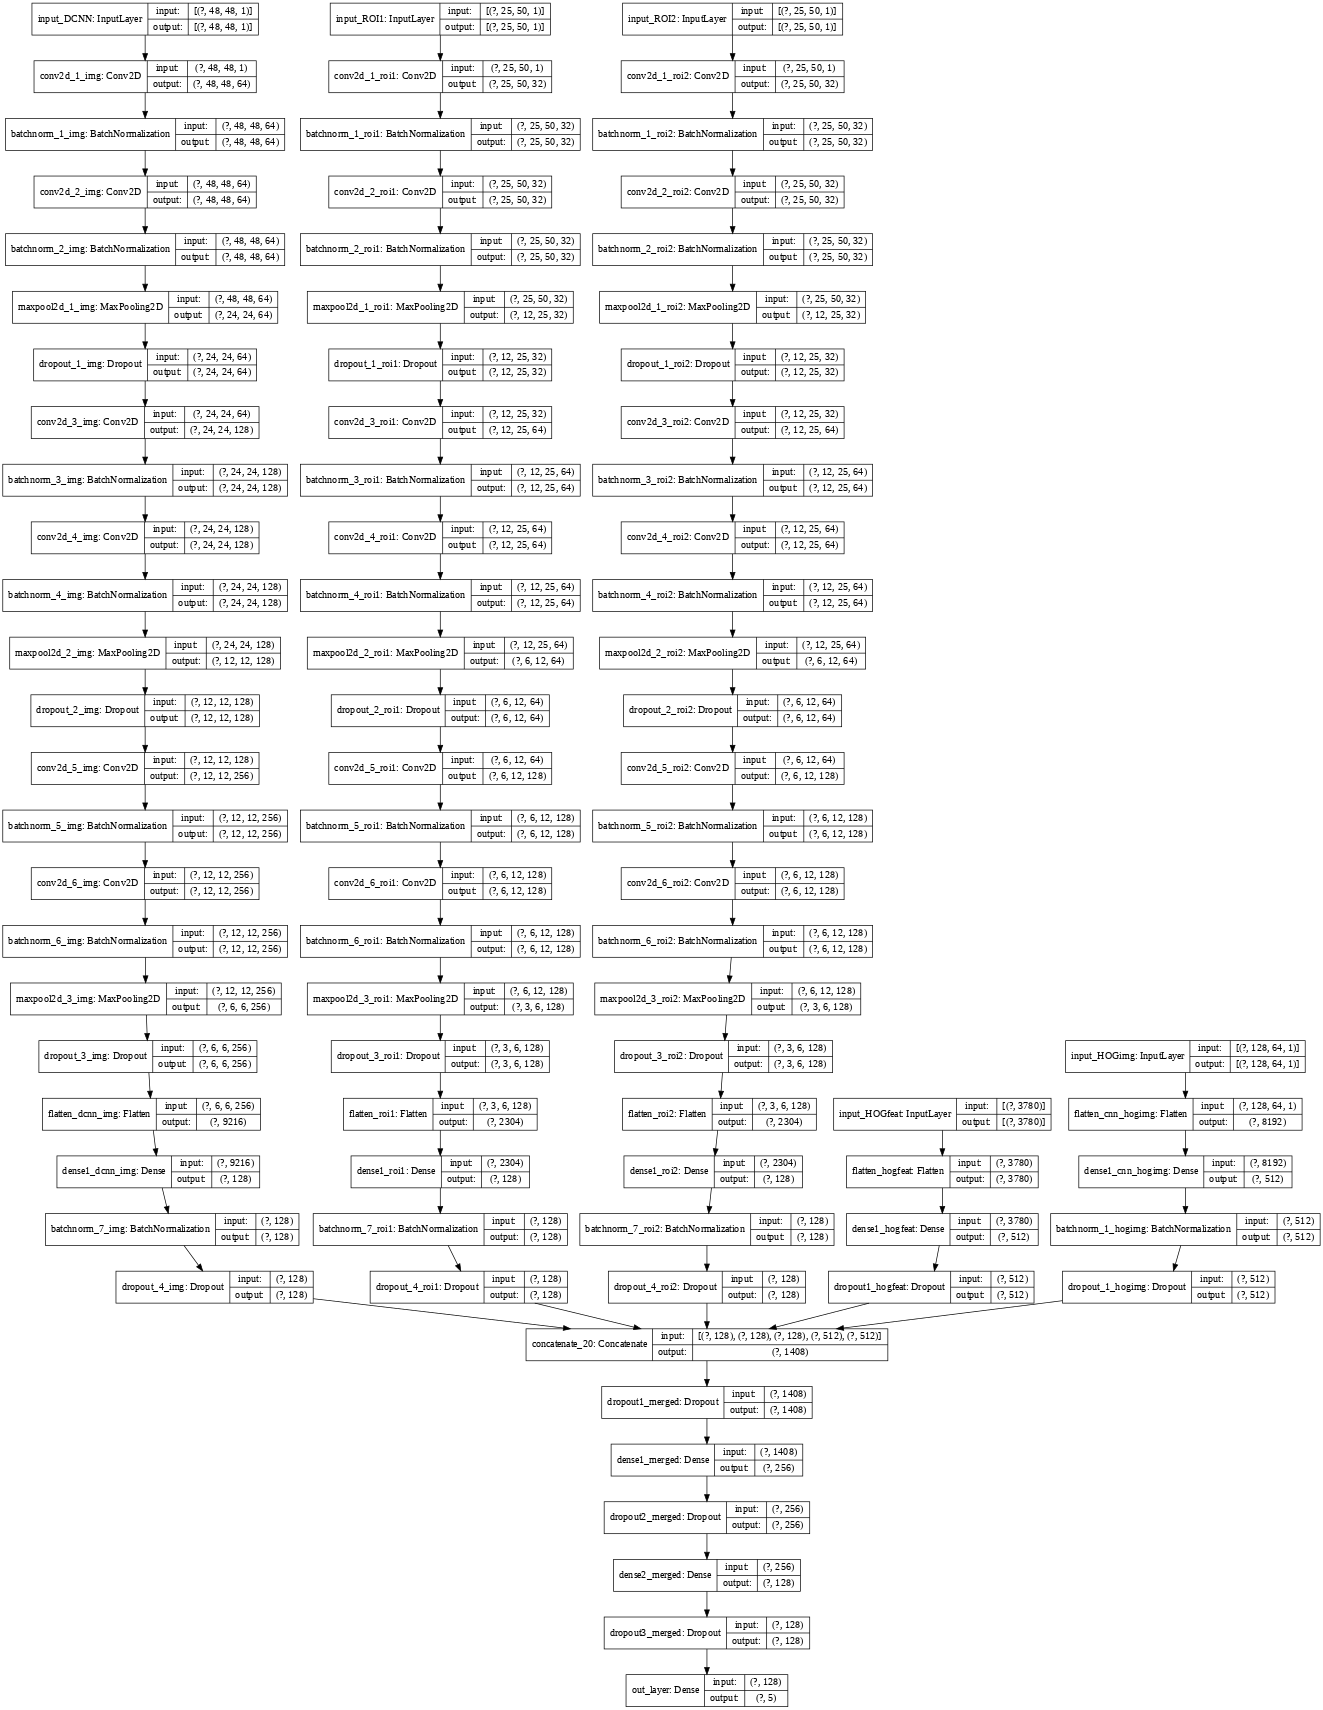

In [0]:
fullimg_in, fullimg_out = full_image_pipeline(input_shape=(48,48,1))
roi1_in, roi1_out = roi1_pipeline(input_shape=(25,50,1))
roi2_in, roi2_out = roi2_pipeline(input_shape=(25,50,1))
hogfeat_in, hogfeat_out = facial_HOGfeat_pipeline(input_shape=(3780))
hogimg_in, hogimg_out = facial_HOGimg_pipeline(input_shape=(128,64,1))

num_classes = y_train.shape[1]

model = merge_models(
    models_in=[fullimg_in, roi1_in, roi2_in, hogfeat_in, hogimg_in],
    models_out=[fullimg_out, roi1_out, roi2_out, hogfeat_out, hogimg_out],
    num_classes=num_classes,
)

model_name = "img+roi1+roi2+hogfeat+hogimg"
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50, to_file=BASE_PATH+f'/{model_name}_model.png')

In [0]:
def data_generator_1(Xtrain_img, Xtrain_roi1, Xtrain_roi2, Xtrain_hogfeat, ytrain, batch_size):
    while True:
        idx = np.random.permutation(Xtrain_img.shape[0])

        datagen_img = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
        )

        datagen_roi = ImageDataGenerator(
            rotation_range=8,
            width_shift_range=0.08,
            height_shift_range=0.08,
            shear_range=0.08,
            zoom_range=0.08,
            horizontal_flip=True,
        )

        batches_img = datagen_img.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)
        batches_roi1 = datagen_roi.flow(Xtrain_roi1[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)
        batches_roi2 = datagen_roi.flow(Xtrain_roi2[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)

        idx0 = 0
        for batchimg, batchroi1, batchroi2 in zip(batches_img, batches_roi1, batches_roi2):
            idx1 = idx0 + batchimg[0].shape[0]

            yield [batchimg[0], batchroi1[0], batchroi2[0], Xtrain_hogfeat[idx[idx0:idx1]] ], batchimg[1]

            idx0 = idx1
            if idx1 >= Xtrain_img.shape[0]:
                break


def data_generator_2(Xtrain_img, Xtrain_roi1, Xtrain_roi2, Xtrain_hogfeat, Xtrain_hogimg, ytrain, batch_size):
    while True:
        idx = np.random.permutation(Xtrain_img.shape[0])

        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
        )

        batches = datagen.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False)

        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], Xtrain_roi1[idx[idx0:idx1]], Xtrain_roi2[idx[idx0:idx1]], Xtrain_hogfeat[idx[idx0:idx1]], Xtrain_hogimg[idx[idx0:idx1]] ], batch[1]

            idx0 = idx1
            if idx1 >= Xtrain_img.shape[0]:
                break

In [0]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00001,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00008,
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    # early_stopping,
    lr_scheduler,
]

In [0]:
batch_size = 16
epochs = 40
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)

model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

history = model.fit(
    data_generator_2(Xtrain_img, Xtrain_roi1, Xtrain_roi2, Xtrain_hogfeat, Xtrain_hogimg, y_train, batch_size=batch_size,),
    validation_data=([Xtest_img, Xtest_roi1, Xtest_roi2, Xtest_hogfeat, Xtest_hogimg], y_test),
    steps_per_epoch=len(Xtrain_img) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/40
33/32 [==============================] - 2s 49ms/step - loss: 1.8712 - accuracy: 0.5867 - val_loss: 8.7153 - val_accuracy: 0.3956 - lr: 0.0010
Epoch 2/40
33/32 [==============================] - 1s 31ms/step - loss: 1.0724 - accuracy: 0.7181 - val_loss: 4.5023 - val_accuracy: 0.3911 - lr: 0.0010
Epoch 3/40
33/32 [==============================] - 1s 28ms/step - loss: 0.6995 - accuracy: 0.7924 - val_loss: 0.5584 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 4/40
33/32 [==============================] - 1s 30ms/step - loss: 0.5096 - accuracy: 0.8667 - val_loss: 0.4422 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 5/40
33/32 [==============================] - 1s 28ms/step - loss: 0.3587 - accuracy: 0.8876 - val_loss: 0.3015 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 6/40
33/32 [==============================] - 1s 29ms/step - loss: 0.3551 - accuracy: 0.8952 - val_loss: 0.4137 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 7/40
33/32 [==============================] - 1s 29ms/step - loss: 0.3

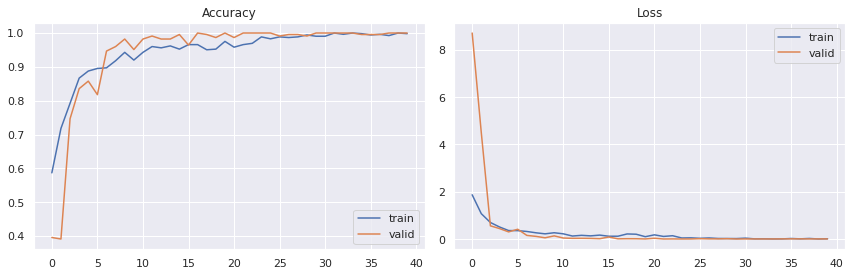

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig(BASE_PATH + f'epoch_metrics/{model_name}_{num_classes}emo.png')
pyplot.show()

In [0]:
label_to_text, text_to_label

({0: 'fear', 1: 'sadness', 2: 'anger', 3: 'surprise', 4: 'happy'},
 {'anger': 2, 'fear': 0, 'happy': 4, 'sadness': 1, 'surprise': 3})

test accuracy: 100.0 %


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        75
           4       1.00      1.00      1.00        62

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225



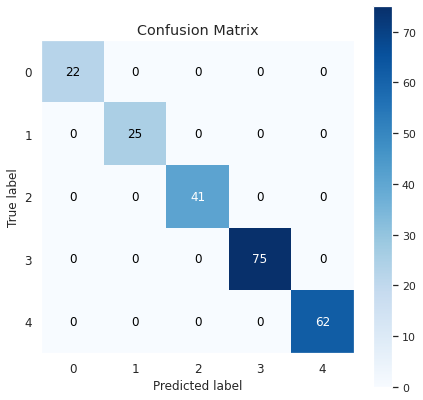

In [0]:
yhat_test = model.predict([Xtest_img, Xtest_roi1, Xtest_roi2, Xtest_hogfeat, Xtest_hogimg])
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig(BASE_PATH + f'confusion_matrix/{model_name}_{num_classes}emo.png')

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))https://colab.research.google.com/drive/10W_lKYcZIDzHbuzYth_kmOkm8FUBy6UW#scrollTo=bNVijEj-7tqZ